In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import mysql.connector

In [2]:
%matplotlib inline

### Begin dictionary of variable types

In [88]:
columns = {'not_needed': ['F_FACILITY', 'MAGE_IMPFLG', 'MAGE_REPFLG', 'MRACE_IMP'],\
          'nominal_categorical':[], 'ordinal_categorical':[], 'continuous':[]}

### Functions to query SQL from python

In [3]:
#function to run simple SQL query from python
def create_table_from_SQL(user, database, password, query):
    '''
    - A function that returns a pandas dataframe from a SQL query in python
    ---------------
    - user: user for your local SQL connection in string format
    - database: schema name where your database is stored in string format
    - password: password to access your local SQL connection in string format
    - query: SQL query in string format; enclose with double quotes and use single quotes
    to designate VARCHAR values within queries; use schema_name.table_name after FROM statement
    '''
    cnx = mysql.connector.connect(user=user, database=database, password=password)
    cursor = cnx.cursor()
    query = query
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall())
    df.columns = cursor.column_names
    return df

In [10]:
#function to create n number of cursor objects from the SQL dataframe to enable chunking

### Initial Data Analysis

#### *Most frequent defects among NICU admitted patients (2018 only)*

In [94]:
query = "SELECT CA_ANEN, CA_MNSB, CA_CCHD, CA_CDH, CA_OMPH,\
        CA_GAST, CA_LIMB, CA_CLEFT, CA_DOWN, CA_DISOR, CA_HYPO, AB_SEIZ\
        FROM cdc_2018\
        WHERE AB_NICU = 'Y'\
        LIMIT 0, 4000000"

In [95]:
nicu_defect = create_table_from_SQL('root','cdc_project','AquiBerk2!', query)

Text(0.5, 1.0, 'Total Number of Patients Admitted to the NICU')

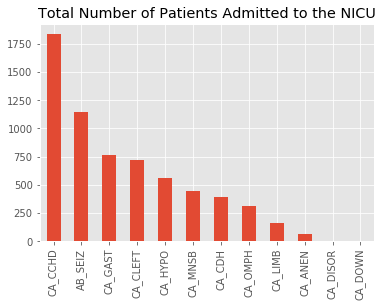

In [116]:
#Cyanotic Congenital Heart Disease, seizures, Gastroschisis show up most frequently among
#NICU admitted patients
nicu_defect.apply(lambda x: sum(x=='Y'), axis=0).sort_values(ascending=False).plot.bar()
plt.title('Total Number of Patients Admitted to the NICU')

#### *Proportion of patients with each defect admitted to NICU vs proportion of non-defect patients admitted - visual results and statistical analysis (2018 only)*

In [8]:
query = "SELECT CA_ANEN, CA_MNSB, CA_CCHD, CA_CDH, CA_OMPH,\
        CA_GAST, CA_LIMB, CA_CLEFT, CA_DOWN, CA_DISOR, CA_HYPO, AB_SEIZ, AB_NICU\
        FROM cdc_2018\
        LIMIT 0, 4000000"

In [9]:
defect_nicu_props = create_table_from_SQL('root','cdc_project','AquiBerk2!', query)

In [14]:
overall_prop=len(defect_nicu_props.AB_NICU[defect_nicu_props.AB_NICU=='Y'])/len(defect_nicu_props.AB_NICU)

In [64]:
admits = pd.DataFrame(defect_nicu_props[defect_nicu_props.AB_NICU=='Y'].apply(lambda x: sum(x=='Y'), axis=0))
total = defect_nicu_props.apply(lambda x: sum(x=='Y'), axis=0)
admits = pd.concat([admits,total], axis=1)
admits.columns = ['Admits', 'Total']
admits['props'] = admits['Admits']/admits['Total']
admits = admits.iloc[0:-1,:]
admits = admits.fillna(value=0)

In [78]:
admits.sort_values(by='props', ascending = False, inplace = True)

Text(0.5, 1.0, 'Proportion of Patients with Defect Admitted to the NICU')

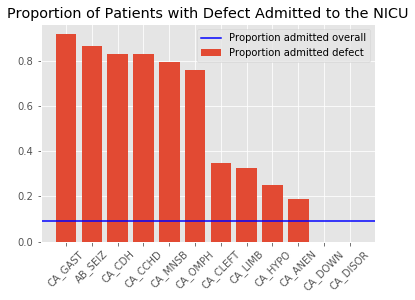

In [118]:
plt.bar(x=admits.index, height = admits.props)
plt.xticks(rotation=45)
plt.axhline(y=overall_prop, color='blue', label='overall NICU admit')
plt.legend(("Proportion admitted overall", "Proportion admitted defect"))
plt.title('Proportion of Patients with Defect Admitted to the NICU')

Text(0.5, 1.0, 'Proportion and Total Admits Two by Two')

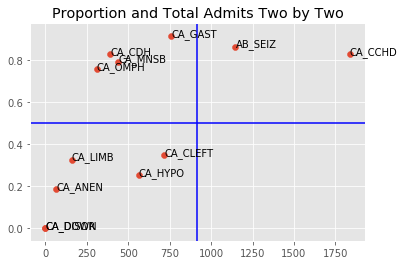

In [117]:
plt.scatter(x=admits.Admits, y=admits.props)
for i, txt in enumerate(admits.index):
    plt.annotate(txt, (admits.Admits[i], admits.props[i]))
plt.axhline(y=0.5, color='blue')
plt.axvline(x=admits['Admits']['CA_CCHD']/2, color='blue')
plt.title('Proportion and Total Admits Two by Two')